In [1]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
%pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# imports
import os

import torch, torchvision
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import CIFAR10

torch.__version__, torchvision.__version__
torch.cuda.is_available()
# Install Albumentation library
%pip install albumentations
# Install LR finder
%pip install torchinfo torch_lr_finder
# Install GradCam
%pip install grad-cam

%pip install tqdm

%pip install torchscan --no-deps

%pip install seaborn

%pip install gradio

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sn  # for heatmaps
import math
from collections import OrderedDict
import sys
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau
import matplotlib.pyplot as plt

from torch_lr_finder import LRFinder

#from pytorch_grad_cam import GradCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
import copy
from torchvision.utils import make_grid, save_image

import gradio as gr


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%` not found.


In [4]:
!git clone https://github.com/nanekja/pytorch_utils

sys.path.append('./pytorch_utils/')
import main
import utils
import transform
import train1
import test1
import dataloader
import albumentation
from PIL import Image
import gradcam

import albumentations as A
from albumentations.pytorch import ToTensorV2
from utils import visualize_cam#, GradCAM

sys.path.append('./pytorch_utils/models/')
import c_resnet

fatal: destination path 'pytorch_utils' already exists and is not an empty directory.


/home/nanekja/.local/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:31<00:00, 5492155.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

0

In [6]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
mean, std = utils.get_mean_and_std()

Files already downloaded and verified
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


Files already downloaded and verified


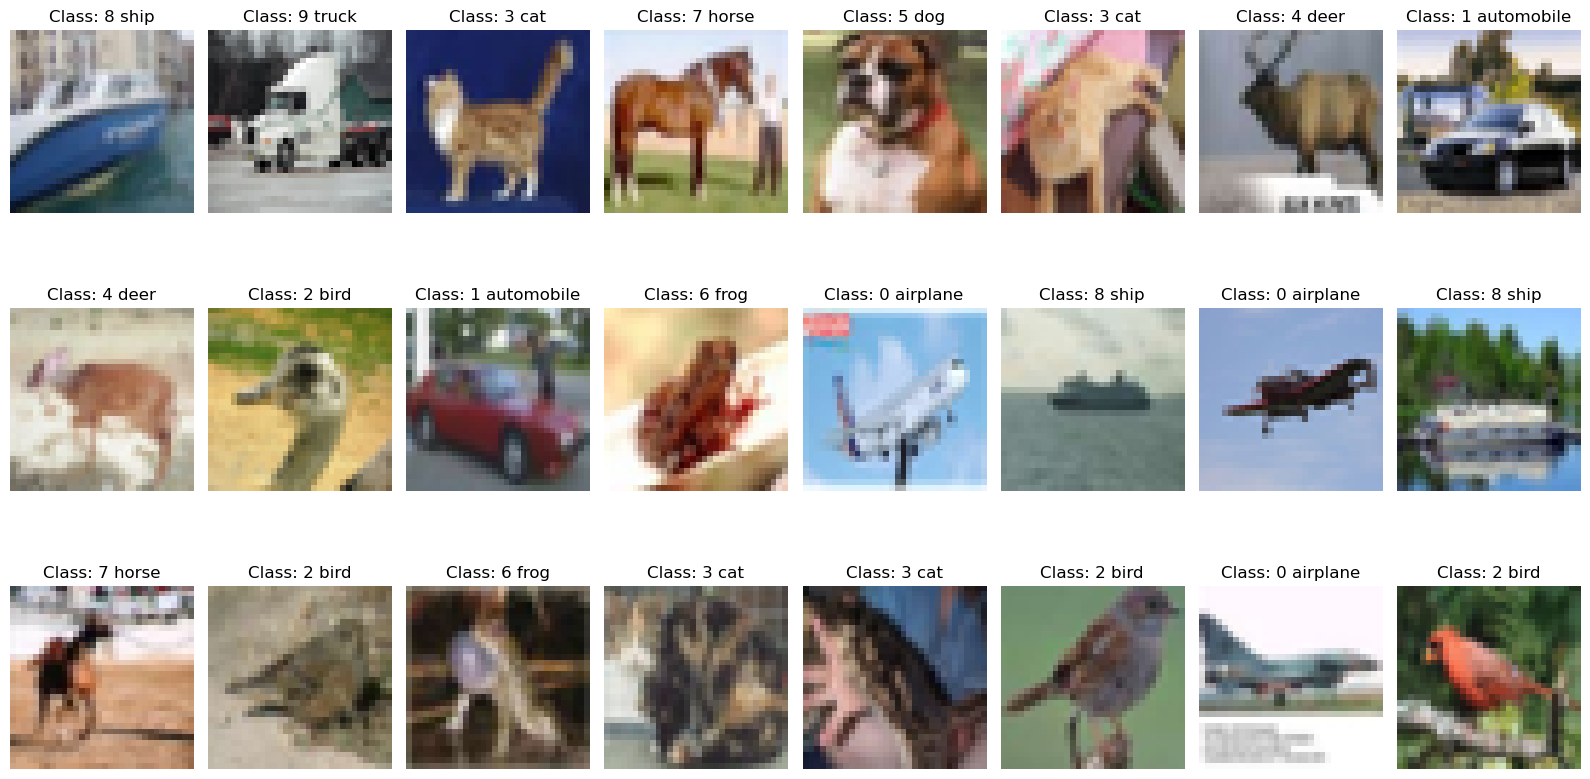

In [8]:
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
utils.plot_data(exp,3,8)

torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


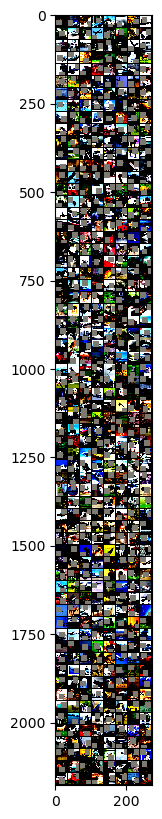

In [9]:
dataiter = iter(transform.train_loader)

images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))

In [10]:
from models import c_resnet
device = utils.get_device()
model = c_resnet.Net().to(device)


from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

______________________________________________________________________________
Layer          Type          Output Shape         Param #      Receptive field
net            Net           (-1, 10)             0            1              
├─layer1       Sequential    (-1, 64, 32, 32)     1,985        3              
├─layer2       Sequential    (-1, 128, 16, 16)    74,241       6              
├─resblock1    Sequential    (-1, 128, 16, 16)    295,938      14             
├─layer3       Sequential    (-1, 256, 8, 8)      295,937      20             
├─layer4       Sequential    (-1, 512, 4, 4)      1,181,697    32             
├─resblock2    Sequential    (-1, 512, 4, 4)      4,722,690    64             
├─pool         MaxPool2d     (-1, 512, 1, 1)      0            88             
├─fc           Linear        (-1, 10)             5,120        88             
Trainable params: 6,573,120
Non-trainable params: 0
Total params: 6,573,120
-------------------------------------------------------

/home/nanekja/.local/lib/python3.10/site-packages/torchscan/process/memory.py:26: UserWarning: CUDA is unavailable to PyTorch.
  warnings.warn("CUDA is unavailable to PyTorch.")


In [11]:
criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0005)

lrmax=0.001
optimizer = optim.Adam(model.parameters(), lr=lrmax)

ideal_lr=utils.find_lr(model, optimizer, criterion, transform.train_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
EPOCHS = 5

#optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0001, nesterov=True)
#scheduler = ReduceLROnPlateau(optimizer, patience = 2)

max_epoch=5
scheduler = OneCycleLR(optimizer=optimizer, max_lr=ideal_lr, epochs=EPOCHS, steps_per_epoch=len(transform.train_loader), pct_start=max_epoch/EPOCHS, verbose = False, div_factor=10, three_phase = False, base_momentum = 0.5)

In [13]:
net, history = main.fit_model(model, device, transform.train_loader, transform.test_loader, optimizer, criterion, scheduler, EPOCHS)

EPOCH: 1 (LR: 0.0004000000000000002)


Batch_id=0 Loss=2.03963 Accuracy=40.43:   1%|          | 1/98 [00:38<1:01:36, 38.11s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
#no_misclf=10

#x_count = 5
#y_count = 1 if no_misclf <= 5 else math.floor(no_misclf / x_count)

#misclf = utils.plot_misclassified2(net, transform.test_loader, transform.testset.classes, device, mean, std, no_misclf, plot_size=(x_count,y_count),return_misclf=True)

wp = utils.wrong_predictions(model, transform.test_loader, device)
utils.plot_misclassified2(wp, mean, std, 10, classes)

In [ ]:
#total_images = 1
#gradcam_misclassified_images = utils.get_misclassified_images(model, device, transform.test_loader, transform.testset.classes, total_images)
#torch.save(gradcam_misclassified_images, "./gorilla.jpg")

In [ ]:
target_layers = ["layer4"]
#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(wp[:10], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, wp[:10], mean, std)